In [1]:
import os, sys
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns 

from os.path import join 
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from IPython.display import display_html

import warnings
warnings.filterwarnings("ignore")

In [2]:
DataPath = r'D:\GitWork\titanic\data'
OutPath  = r'D:\GitWork\titanic\output'

f_abspath = join(DataPath, 'train.csv')
df_train = pd.read_csv(f_abspath)

f_abspath = join(DataPath, 'test.csv')
df_test = pd.read_csv(f_abspath)

df_data = df_train.append(df_test)
display(df_data.head())
display(df_data.info())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


None

In [3]:
def plotBarStacked(df_plt, ax, title=None, xlabel=None, ylabel=None):
    ax.set_title('{} stacked'.format(title))
    ax.set_xlabel('{}'.format(xlabel))
    ax.set_ylabel('{}'.format(ylabel))
    df_plt.plot(kind='bar', stacked=True, rot=0, ax=ax)

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        left, bottom = p.get_xy()
        val = bottom + height
        ax.annotate(
            '{}'.format(val),
            xy = (left + width/2, val),
            xytext = (0,2),
            textcoords = "offset points",
            ha = 'center', 
            va = 'bottom'
        )
    return

def plotBarUnstack(df_plt, ax, title=None, xlabel=None, ylabel=None):
    ax.set_title('{}'.format(title))
    ax.set_xlabel('{}'.format(xlabel))
    ax.set_ylabel('{}'.format(ylabel))
    df_plt.plot(kind='bar', stacked=False, rot=0, ax=ax)

    for p in ax.patches:
        width  = p.get_width()
        height = p.get_height()
        left, bottom = p.get_xy()
        val = p.get_height()
        ax.annotate(
            '{}'.format(val),
            xy = (left+width/2, height),
            xytext = (0,1),
            textcoords = "offset points",
            ha = 'center', 
            va = 'bottom'
        )
    return


In [4]:
# Preprocess: Name

# def getTitle(name):
#     if '.' in name:
#         return name.split(',')[1].split('.')[0].strip()
#     else:
#         return 'unknown'
# df_data['Title'] = df_data.Name.map(lambda x: getTitle(x))

col_selected = ['Title','Name_1','Name_2','Name_3']
for col in col_selected: df_data[col] = None

for idx, row in df_data.iterrows():
    instr = row.Name
    if ',' in instr:
        splits = instr.split(',')
        name1  = splits[0].strip()
        instr  = splits[1].strip()
    else:
        name1 = 'unknown'

    if '.' in instr:
        splits = instr.split('.')
        title  = splits[0].strip()
        instr  = splits[1].strip()
    else:
        title = 'unknown'
        
    name2 = instr
    name3 = ''
    
    pattern = r'\([A-Za-z \'\"\.-]+\)\"?'
    match = re.findall(pattern, name2)
    if match:
        name3 = match[0].strip()
        name2 = name2.replace(name3,'').strip()
        
    mask = (df_data.PassengerId == row.PassengerId)
    df_data.loc[mask, col_selected] = [title,name1,name2,name3]

display(df_data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Name_1,Name_2,Name_3
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,Owen Harris,
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,John Bradley,(Florence Briggs Thayer)
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,Laina,
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,Jacques Heath,(Lily May Peel)
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,William Henry,


In [5]:
# Preprocess: Family = SibSp + Parch

df_data['Family'] = df_data.SibSp + df_data.Parch

kwargs = { 'margins': True, 'margins_name': 'Total'}

pt = pd.pivot_table(
    df_data,
    index   = 'Family', 
    columns = 'Survived', 
    values  = 'PassengerId', 
    aggfunc = 'count',
    **kwargs
).fillna(0).astype(int)
pt['Rate_S1'] = (pt[1.0] / pt.Total).round(4)

display(pt)

Survived,0.0,1.0,Total,Rate_S1
Family,,,,
0,374,163,537,0.3035
1,72,89,161,0.5528
2,43,59,102,0.5784
3,8,21,29,0.7241
4,12,3,15,0.2000
5,19,3,22,0.1364
6,8,4,12,0.3333
7,6,0,6,0.0000
10,7,0,7,0.0000


In [6]:
# Fill missing values

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin:10px"'), raw=True)
    return

df1 = df_train.isnull().sum().to_frame().rename(columns={0:'Train null values'})
df2 = df_test.isnull().sum().to_frame().rename(columns={0:'Test null values'})
df3 = df_data.isnull().sum().to_frame().rename(columns={0:'All null values'})

display_side_by_side(df1, df2, df3)

,Train null values
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [7]:
# Fill missing values: Fare

display(df_data.Fare.describe())

df = df_data[df_data.Fare.isnull()]
display(df)

mask = (df_data.Pclass==3)
print('Describe of Fare of Pclass 3:')
display(df_data[mask].Fare.describe())

median_fare = df_data[mask].Fare.median()
print('Median of Fare of Pclass 3:', median_fare)

mean_fare = df_data[mask].Fare.mean().round(3)
print('\nFill missing fare with {}', mean_fare)

df_data['Fare_F'] = df_data.Fare.copy().round(3)
df_data.Fare_F.fillna(mean_fare, inplace=True)

display(df_data.Fare_F.describe())

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Name_1,Name_2,Name_3,Family
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr,Storey,Thomas,,0


Describe of Fare of Pclass 3:


count    708.000000
mean      13.302889
std       11.494358
min        0.000000
25%        7.750000
50%        8.050000
75%       15.245800
max       69.550000
Name: Fare, dtype: float64

Median of Fare of Pclass 3: 8.05

Fill missing fare with {} 13.303


count    1309.000000
mean       33.280201
std        51.741827
min         0.000000
25%         7.896000
50%        14.454000
75%        31.275000
max       512.329000
Name: Fare_F, dtype: float64

In [8]:
# Fill missing values: Embarked

display(df_data.Embarked.describe(include=['O']))

df = df_data[df_data.Embarked.isnull()]
display(df)

df = df_data[df_data.Cabin.notnull()]

# If exist the same fare tickets?
mask = (df.Fare==80.0)
display(df[mask])

# The passenger is single, pclass 1 and cabin head 'B2'
mask = ((df.Pclass==1) & (df.Sex=='female') & df.Cabin.str.startswith('B2'))
display(df[mask])
df = df[mask].groupby('Embarked')['PassengerId'].agg('count').to_frame() 
display(df)

most_embarked = df.PassengerId.idxmax()
print("Fill missing Embarked with '{}'".format(most_embarked))

df_data['Embarked_F'] = df_data.Embarked.copy()
df_data.Embarked_F.fillna(most_embarked, inplace=True)

display(df_data.Embarked_F.describe(include=['O']))

count     1307
unique       3
top          S
freq       914
Name: Embarked, dtype: object

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Name_1,Name_2,Name_3,Family,Fare_F
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,Icard,Amelie,,0,80.0
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,Stone,George Nelson,(Martha Evelyn),0,80.0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Name_1,Name_2,Name_3,Family,Fare_F
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,Icard,Amelie,,0,80.0
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,Stone,George Nelson,(Martha Evelyn),0,80.0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Name_1,Name_2,Name_3,Family,Fare_F
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.00,B28,NaN,Miss,Icard,Amelie,,0,80.00
540,541,1.0,1,"Crosby, Miss. Harriet R",female,36.0,0,2,WE/P 5735,71.00,B22,S,Miss,Crosby,Harriet R,,2,71.00
781,782,1.0,1,"Dick, Mrs. Albert Adrian (Vera Gillespie)",female,17.0,1,0,17474,57.00,B20,S,Mrs,Dick,Albert Adrian,(Vera Gillespie),1,57.00
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.00,B28,NaN,Mrs,Stone,George Nelson,(Martha Evelyn),0,80.00
305,1197,NaN,1,"Crosby, Mrs. Edward Gifford (Catherine Elizabe...",female,64.0,1,1,112901,26.55,B26,S,Mrs,Crosby,Edward Gifford,(Catherine Elizabeth Halstead),2,26.55


,PassengerId
Embarked,
S,3


Fill missing Embarked with 'S'


count     1309
unique       3
top          S
freq       916
Name: Embarked_F, dtype: object

In [9]:
# Explore missing values: Age

display(df_data.Age.describe())

ct1 = df_data.groupby('Title').agg({'Age':['mean','median']}).round(3)

# ct1 = df_data.groupby('Title').agg(
#     mean=('Age', 'mean'), median=('Age','median')
# ).round(4)

ct2 = pd.crosstab(
    df_data.Title, 
    df_data.Sex, 
    values  = df_data.PassengerId, 
    aggfunc = ['count'], 
    **kwargs
).fillna(0).astype(int)

ct3 = pd.crosstab(
    df_data.Title, 
    df_data.Sex, 
    values  = df_data.Age, 
    aggfunc = ['count'], 
    **kwargs
).fillna(0).astype(int)

display_side_by_side(ct1, ct2, ct3)

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

Age 
 
 
 
 mean 
 median 
 
 
 Title 
 
 
 
 
 
 
 Capt 
 70.000 
 70.0 
 
 
 Col 
 54.000 
 54.5 
 
 
 Don 
 40.000 
 40.0 
 
 
 Dona 
 39.000 
 39.0 
 
 
 Dr 
 43.571 
 49.0 
 
 
 Jonkheer 
 38.000 
 38.0 
 
 
 Lady 
 48.000 
 48.0 
 
 
 Major 
 48.500 
 48.5 
 
 
 Master 
 5.483 
 4.0 
 
 
 Miss 
 21.774 
 22.0 
 
 
 Mlle 
 24.000 
 24.0 
 
 
 Mme 
 24.000 
 24.0 
 
 
 Mr 
 32.252 
 29.0 
 
 
 Mrs 
 36.994 
 35.5 
 
 
 Ms 
 28.000 
 28.0 
 
 
 Rev 
 41.250 
 41.5 
 
 
 Sir 
 49.000 
 49.0 
 
 
 the Countess 
 33.000 
 33.0 
 
 
 
 
 
 
 count 
 
 
 Sex 
 female 
 male 
 Total 
 
 
 Title 
 
 
 
 
 
 
 
 Capt 
 0 
 1 
 1 
 
 
 Col 
 0 
 4 
 4 
 
 
 Don 
 0 
 1 
 1 
 
 
 Dona 
 1 
 0 
 1 
 
 
 Dr 
 1 
 7 
 8 
 
 
 Jonkheer 
 0 
 1 
 1 
 
 
 Lady 
 1 
 0 
 1 
 
 
 Major 
 0 
 2 
 2 
 
 
 Master 
 0 
 61 
 61 
 
 
 Miss 
 260 
 0 
 260 
 
 
 Mlle 
 2 
 0 
 2 
 
 
 Mme 
 1 
 0 
 1 
 
 
 Mr 
 0 
 757 
 757 
 
 
 Mrs 
 197 
 0 
 197 
 
 
 Ms 
 2 
 0 
 2 
 
 
 Rev 
 0 
 8 
 8 
 
 
 Sir 
 0 
 1 
 1 
 
 
 the Countess 
 1 
 0 
 1 
 
 
 Total 
 466 
 843 
 1309 
 
 
 
 
 
 
 count 
 
 
 Sex 
 female 
 male 
 Total 
 
 
 Title 
 
 
 
 
 
 
 
 Capt 
 0 
 1 
 1 
 
 
 Col 
 0 
 4 
 4 
 
 
 Don 
 0 
 1 
 1 
 
 
 Dona 
 1 
 0 
 1 
 
 
 Dr 
 1 
 6 
 7 
 
 
 Jonkheer 
 0 
 1 
 1 
 
 
 Lady 
 1 
 0 
 1 
 
 
 Major 
 0 
 2 
 2 
 
 
 Master 
 0 
 53 
 53 
 
 
 Miss 
 210 
 0 
 210 
 
 
 Mlle 
 2 
 0 
 2 
 
 
 Mme 
 1 
 0 
 1 
 
 
 Mr 
 0 
 581 
 581 
 
 
 Mrs 
 170 
 0 
 170 
 
 
 Ms 
 1 
 0 
 1 
 
 
 Rev 
 0 
 8 
 8 
 
 
 Sir 
 0 
 1 
 1 
 
 
 the Countess 
 1 
 0 
 1 
 
 
 Total 
 388 
 658 
 1046

In [10]:
# Fill missing values: Age 

df_data['Age_F'] = df_data.Age.copy()

median_Dr  = df_data[df_data.Age_F.notnull() & (df_data.Title=='Dr')]['Age'].median()
median_Mas = df_data[df_data.Age_F.notnull() & (df_data.Title=='Master')]['Age'].median()
median_Mis = df_data[df_data.Age_F.notnull() & (df_data.Title=='Miss')]['Age'].median()
median_Mr  = df_data[df_data.Age_F.notnull() & (df_data.Title=='Mr')]['Age'].median()
median_Mrs = df_data[df_data.Age_F.notnull() & (df_data.Title=='Mrs')]['Age'].median()
median_Ms  = df_data[df_data.Age_F.notnull() & (df_data.Title=='Ms')]['Age'].median()

df_data.loc[df_data.Age_F.isnull() & (df_data.Title=='Dr'),     'Age_F'] = median_Dr
df_data.loc[df_data.Age_F.isnull() & (df_data.Title=='Master'), 'Age_F'] = median_Mas
df_data.loc[df_data.Age_F.isnull() & (df_data.Title=='Miss'),   'Age_F'] = median_Mis
df_data.loc[df_data.Age_F.isnull() & (df_data.Title=='Mr'),     'Age_F'] = median_Mr
df_data.loc[df_data.Age_F.isnull() & (df_data.Title=='Mrs'),    'Age_F'] = median_Mrs
df_data.loc[df_data.Age_F.isnull() & (df_data.Title=='Ms'),     'Age_F'] = median_Ms

ct2 = pd.crosstab(
    df_data.Title, 
    df_data.Sex, 
    values = df_data.Age, 
    aggfunc=['count'], 
    **kwargs
).fillna(0).astype(int)

ct3 = pd.crosstab(
    df_data.Title, 
    df_data.Sex, 
    values = df_data.Age_F, 
    aggfunc=['count'], 
    **kwargs
).fillna(0).astype(int)

display_side_by_side(ct2, ct3)

count 
 
 
 Sex 
 female 
 male 
 Total 
 
 
 Title 
 
 
 
 
 
 
 
 Capt 
 0 
 1 
 1 
 
 
 Col 
 0 
 4 
 4 
 
 
 Don 
 0 
 1 
 1 
 
 
 Dona 
 1 
 0 
 1 
 
 
 Dr 
 1 
 6 
 7 
 
 
 Jonkheer 
 0 
 1 
 1 
 
 
 Lady 
 1 
 0 
 1 
 
 
 Major 
 0 
 2 
 2 
 
 
 Master 
 0 
 53 
 53 
 
 
 Miss 
 210 
 0 
 210 
 
 
 Mlle 
 2 
 0 
 2 
 
 
 Mme 
 1 
 0 
 1 
 
 
 Mr 
 0 
 581 
 581 
 
 
 Mrs 
 170 
 0 
 170 
 
 
 Ms 
 1 
 0 
 1 
 
 
 Rev 
 0 
 8 
 8 
 
 
 Sir 
 0 
 1 
 1 
 
 
 the Countess 
 1 
 0 
 1 
 
 
 Total 
 388 
 658 
 1046 
 
 
 
 
 
 
 count 
 
 
 Sex 
 female 
 male 
 Total 
 
 
 Title 
 
 
 
 
 
 
 
 Capt 
 0 
 1 
 1 
 
 
 Col 
 0 
 4 
 4 
 
 
 Don 
 0 
 1 
 1 
 
 
 Dona 
 1 
 0 
 1 
 
 
 Dr 
 1 
 7 
 8 
 
 
 Jonkheer 
 0 
 1 
 1 
 
 
 Lady 
 1 
 0 
 1 
 
 
 Major 
 0 
 2 
 2 
 
 
 Master 
 0 
 61 
 61 
 
 
 Miss 
 260 
 0 
 260 
 
 
 Mlle 
 2 
 0 
 2 
 
 
 Mme 
 1 
 0 
 1 
 
 
 Mr 
 0 
 757 
 757 
 
 
 Mrs 
 197 
 0 
 197 
 
 
 Ms 
 2 
 0 
 2 
 
 
 Rev 
 0 
 8 
 8 
 
 
 Sir 
 0 
 1 
 1 
 
 
 the Countess 
 1 
 0 
 1 
 
 
 Total 
 466 
 843 
 1309

In [11]:
# Merge Titles
# ther are 6 clssses, i.e. Master, Mr, Miss, Mrs, Midlife (35-50), Mature (50-80)

df_data['Title_F'] = df_data.Title.copy()
print(sorted(df_data.Title_F.unique()))

# df_data.Title_F.replace(['Master'], 'Master', inplace=True)
# df_data.Title_F.replace(['Mr'],  'Mr', inplace=True)

df_data.Title_F.replace(['Mlle','Mme', 'Ms'], 'Miss', inplace=True)
df_data.Title_F.replace(['the Countess'], 'Mrs', inplace=True)

mask = ['Don','Dona','Dr','Jonkheer','Lady','Major','Rev','Sir']
df_data.Title_F.replace(mask, 'Midlife', inplace=True)

df_data.Title_F.replace(['Capt','Col'], 'Mature', inplace=True)

display(sorted(df_data.Title_F.unique()))

ct = df_data.groupby('Title_F').agg(Count=('Title_F','count')).round(3)
display(ct)

['Capt', 'Col', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess']


['Master', 'Mature', 'Midlife', 'Miss', 'Mr', 'Mrs']

,Count
Title_F,
Master,61
Mature,5
Midlife,23
Miss,265
Mr,757
Mrs,198


In [12]:
# Explore missing values: Cabin

display(df_data.Cabin.describe(include=['O']))

df_data['Cabin_F'] = df_data.apply(lambda x: x.Cabin[0] if pd.notnull(x.Cabin) else '-', axis=1)

pt1 = pd.pivot_table(
    df_data,
    index   = 'Cabin_F',
    columns = 'Pclass',
    values  = 'PassengerId',
    aggfunc = len,
    **kwargs
).fillna('-')

pt2 = pd.pivot_table(
    df_data[df_data.Survived.notnull()],
    index   = 'Cabin_F',
    columns = 'Pclass',
    values  = 'PassengerId',
    aggfunc = len,
    **kwargs
).fillna('-')

pt3 = pd.pivot_table(
    df_data[df_data.Survived.notnull()],
    index   = 'Cabin_F',
    columns = 'Survived',
    values  = 'PassengerId',
    aggfunc = len,
    **kwargs
).fillna(0).astype(int)
pt3['Rate_S1'] = (pt3[1.0]/pt3.Total).round(4)

display_side_by_side(pt1, pt2, pt3)

# pt4 = pd.pivot_table(
#     df_data,
#     index   = 'Cabin_Head',
#     columns = ['Survived','Pclass'],
#     values  = 'Cabin_F',
#     aggfunc = len,
#     **kwargs
# ).fillna('-')
# print()
# display_side_by_side(pt3, pt4)


count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object

Pclass,1,2,3,Total
Cabin_F,,,,
-,67,254,693,1014
A,22,-,-,22
B,65,-,-,65
C,94,-,-,94
D,40,6,-,46
E,34,4,3,41
F,-,13,8,21
G,-,-,5,5
T,1,-,-,1


In [13]:
# Fill missing values: Cabin

# If Survied is alive, fill missing cabin as 'B'
mask = ((df_data.Survived==1) & (df_data.Cabin_F=='-'))
df_data.loc[mask, 'Cabin_F'] = 'B'

# If Survied is dead, fill missing cabin as 'G'
mask = ((df_data.Survived==0) & (df_data.Cabin_F=='-'))
df_data.loc[mask, 'Cabin_F'] = 'G'

# If Survived is null and Pclass is 1, fill missing cabin as 'B'
mask = (df_data.Survived.isnull() & (df_data.Cabin_F=='-') & (df_data.Pclass==1))
df_data.loc[mask, 'Cabin_F'] = 'B'

# If Survived is null and Pclass is 2, fill missing cabin as 'F'
mask = (df_data.Survived.isnull() & (df_data.Cabin_F=='-') & (df_data.Pclass==2))
df_data.loc[mask, 'Cabin_F'] = 'F'

# If Survived is null and Pclass is 3, fill missing cabin as 'G'
mask = (df_data.Survived.isnull() & (df_data.Cabin_F=='-') & (df_data.Pclass==3))
df_data.loc[mask, 'Cabin_F'] = 'G'

pt = pd.pivot_table(
    df_data,
    index   = 'Cabin_F',
    columns = 'Pclass',
    values  = 'PassengerId',
    aggfunc = len,
    **kwargs
).fillna('-')
display(pt)

Pclass,1,2,3,Total
Cabin_F,,,,
A,22,-,-,22
B,111,74,113,298
C,94,-,-,94
D,40,6,-,46
E,34,4,3,41
F,-,99,8,107
G,21,94,585,700
T,1,-,-,1
Total,323,277,709,1309


In [14]:
# Explore: Ticket

df_data['Ticket_F'] = df_data.Ticket.str.extract('([A-Za-z]*)', expand=False).str.upper()
print(df_data.Ticket_F.unique())

['A' 'PC' 'STON' '' 'PP' 'C' 'SC' 'S' 'CA' 'SO' 'W' 'SOTON' 'FA' 'LINE'
 'F' 'SW' 'SCO' 'P' 'WE' 'AQ' 'LP']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Age_F        1309 non-null   float64
 2   Cabin_F      1309 non-null   object 
 3   Embarked_F   1309 non-null   object 
 4   Family       1309 non-null   int64  
 5   Fare_F       1309 non-null   float64
 6   Pclass       1309 non-null   int64  
 7   Sex          1309 non-null   object 
 8   Survived     891 non-null    float64
 9   Ticket_F     1309 non-null   object 
 10  Title        1309 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 162.7+ KB


None

<AxesSubplot:xlabel='x', ylabel='y'>

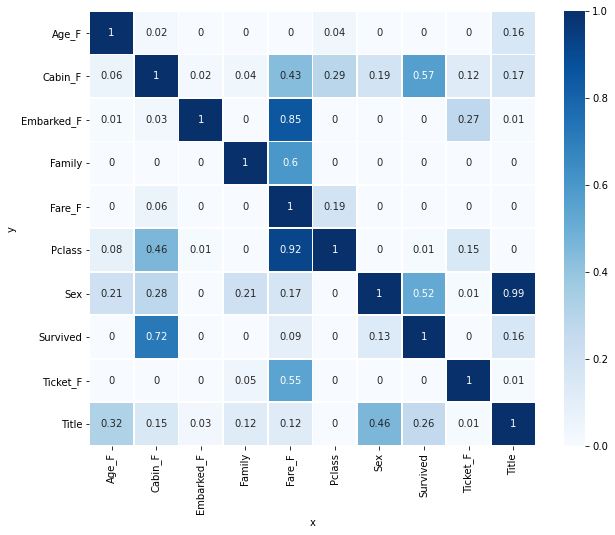

In [15]:
col_selected = [
    'PassengerId','Age_F','Cabin_F','Embarked_F','Family','Fare_F','Pclass','Sex','Survived','Ticket_F','Title'
]
df = df_data[col_selected]
display(df.info())

# PPS (Predictive Power Score)
import ppscore as pps # importing ppscore

col_selected = ['Age_F','Cabin_F','Embarked_F','Family','Fare_F','Pclass','Sex','Survived','Ticket_F','Title']
df_pps = df_data[col_selected]

fig, ax = plt.subplots(figsize=(10,8)) 
matrix_df = pps.matrix(df_pps)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
matrix_df = matrix_df.apply(lambda x: round(x, 2)) # Rounding matrix_df's values to 0, XX

g = sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.75, annot=True, ax=ax)
display(g)

In [16]:
# Transform: Sex

le = LabelEncoder()
df_data['Sex_Code'] = le.fit_transform(df_data.Sex)

dict_sex = dict(zip(le.classes_, le.transform(le.classes_)))
display(dict_sex)

{'female': 0, 'male': 1}

In [17]:
# Transform: Title

le = LabelEncoder()
df_data['Title_Code'] = le.fit_transform(df_data.Title_F)

dict_title = dict(zip(le.classes_, le.transform(le.classes_)))
display(dict_title)

{'Master': 0, 'Mature': 1, 'Midlife': 2, 'Miss': 3, 'Mr': 4, 'Mrs': 5}

In [18]:
# Transform: Fare

df_data['Fare_Bin5'] = pd.qcut(df_data.Fare_F, 5)

le = LabelEncoder()
df_data['Fare_Bin5_Code'] = le.fit_transform(df_data.Fare_Bin5)

df_data.drop('Fare_Bin5', axis=1, inplace=True)

dict_fare = dict(zip(le.classes_, le.transform(le.classes_)))
print('Dict fare:'); display(dict_fare)

Dict fare:


{Interval(-0.001, 7.854, closed='right'): 0,
 Interval(7.854, 10.5, closed='right'): 1,
 Interval(10.5, 21.558, closed='right'): 2,
 Interval(21.558, 41.579, closed='right'): 3,
 Interval(41.579, 512.329, closed='right'): 4}

In [19]:
# Add column: Connected_Survived
#
df_data['Connected_Survival'] = 0.5

for tk, df_grp in df_data.groupby('Ticket'):
    if (len(df_grp) > 1):
        for idx, row in df_grp.iterrows():
            smax = df_grp.drop(idx).Survived.max()
            smin = df_grp.drop(idx).Survived.min()
            passId = row.PassengerId
            if (smax == 1.0):
                df_data.loc[df_data.PassengerId == passId, 'Connected_Survival'] = 1
            elif (smax == 0.0):
                df_data.loc[df_data.PassengerId == passId, 'Connected_Survival'] = 0

df = df_data.groupby('Connected_Survival')['Connected_Survival'].agg(['count']).astype(int)
pt.loc['Total'] = df.sum(axis=0)
display(df)

# num_same_tk = len(df_data.groupby('Ticket').count() > 1)
len_tk_same = len(df_data.Ticket.value_counts() > 1)
print('People keep same ticket: {}'.format(len_tk_same))

len_tk_conn = df_data[df_data.Connected_Survival != 0.5]['Connected_Survival'].count()
print('People have connected infomation: {}'.format(len_tk_conn))

col_selected = ['PassengerId','Survived','Family','Ticket','Connected_Survival']
df = df_data[col_selected]

ct = pd.crosstab(
    df.Connected_Survival,
    df.Survived,
    values  = df.PassengerId,
    aggfunc = ['count'],
    **kwargs
).astype(int)
ct = ct.rename(columns=lambda x: x.replace('count','Count') if isinstance(x,str) else x)
ct[('Rate','S1')] = (ct[('Count',1.0)]/ct[('Count','Total')]).round(3)
display(ct)

,count
Connected_Survival,
0.0,202
0.5,813
1.0,294


People keep same ticket: 929
People have connected infomation: 496


Count              Rate
Survived             0.0  1.0 Total     S1
Connected_Survival                        
0.0                  110   32   142  0.225
0.5                  384  163   547  0.298
1.0                   55  147   202  0.728
Total                549  342   891  0.384

Pclass vs Survived:


Survived,0.0,1.0
Pclass,,
1,80,136
2,97,87
3,372,119


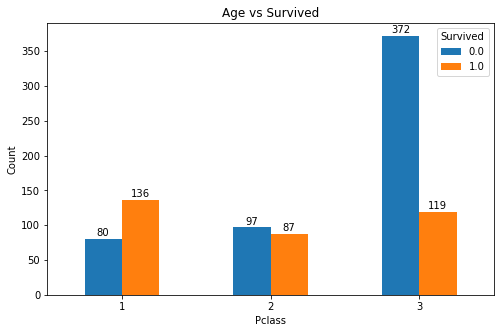

In [20]:
# Explore: Pclass vs Survived

col_selected = ['PassengerId','Survived','Sex_Code','Pclass']
df = df_data[col_selected]

df_plt = pd.crosstab(index=df.Pclass, columns=df.Survived)
print('Pclass vs Survived:')
display_html(df_plt.to_html().replace('table','table style="display:inline;margin:30px"'), raw=True)
fig, ax = plt.subplots(figsize=(8,5))
plotBarUnstack(df_plt,  ax, 'Age vs Survived', 'Age', 'Count')
plt.show()

Bins: [0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80]

Dict Age_Code:
 {0: Interval(0, 8, closed='right'), 1: Interval(8, 16, closed='right'), 2: Interval(16, 24, closed='right'), 3: Interval(24, 32, closed='right'), 4: Interval(32, 40, closed='right'), 5: Interval(40, 48, closed='right'), 6: Interval(48, 56, closed='right'), 7: Interval(56, 64, closed='right'), 8: Interval(64, 72, closed='right'), 9: Interval(72, 80, closed='right')}


Survived,0.0,1.0
Age_FBin,,
"(0, 8]",20,38
"(8, 16]",27,19
"(16, 24]",128,85
"(24, 32]",209,79
"(32, 40]",69,66
"(40, 48]",46,24
"(48, 56]",25,21
"(56, 64]",15,9
"(64, 72]",9,0


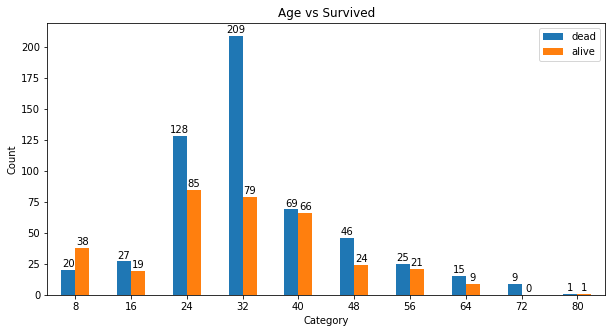

In [21]:
# Explore: Age vs Survival in pclass classes

age_min = int(df_data.Age_F.min())
age_max = int(df_data.Age_F.max())

start = age_min
stop  = age_max + (1 if df_data.Age_F.max()>=age_max else 0)
step  = int((stop-start) / 10)
bins = [x for x in range(start, stop, step)]
print('Bins:', bins)

cuts = pd.cut(df_data.Age_F, bins)
# print(cuts.cat.categories.tolist())

df_data['Age_FBin'] = cuts.values

le = LabelEncoder()
df_data['Age_Code'] = le.fit_transform(df_data.Age_FBin)

dict_age = dict(zip(le.transform(le.classes_), le.classes_))
print('\nDict Age_Code:\n', dict_age)

col_selected = ['PassengerId', 'Survived', 'Pclass', 'Age_FBin']
df = df_data[col_selected]

# Analysis of Age vs Survived
ct = pd.crosstab(
    index   = df.Age_FBin, 
    columns = df.Survived,
    values  = df.PassengerId,
    aggfunc = 'count'
).fillna(0).astype(int)
display(ct)

df_plt = ct.reset_index().rename_axis(None, axis=1).rename(
    columns={'Age_FBin':'Category', 0.0:'dead', 1.0:'alive'}
)
df_plt.index = df_plt.Category.apply(lambda x: x.right)
df_plt.drop('Category', axis=1, inplace=True)
# display(df_plt)
fig, ax = plt.subplots(figsize=(10,5))
plotBarUnstack(df_plt, ax, 'Age vs Survived', 'Age', 'Count')
plt.show()

[8, 16, 24, 32, 40, 48, 56, 64, 72, 80]


Survived,0.0,1.0
Age_FBin,,
"(0, 8]",1,2
"(8, 16]",0,6
"(16, 24]",7,24
"(24, 32]",24,25
"(32, 40]",10,40
"(40, 48]",12,15
"(48, 56]",12,16
"(56, 64]",9,7
"(64, 72]",5,0


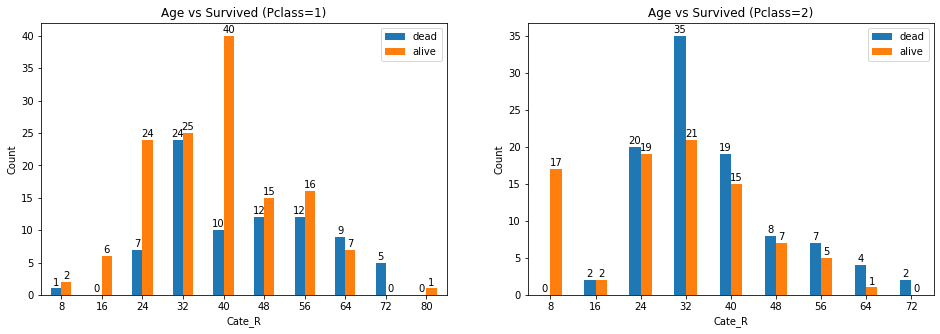

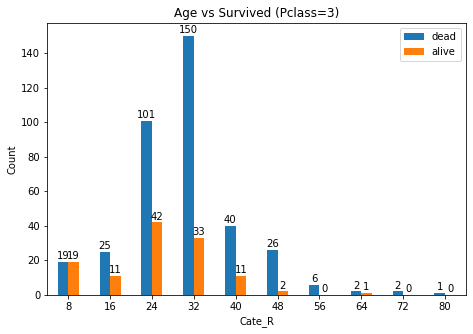

In [22]:
# Explore 

df1 = df[df.Pclass==1]
df2 = df[df.Pclass==2]
df3 = df[df.Pclass==3]

new_index = sorted([x.right for x in df.Age_FBin.unique()])
print(new_index)

ct1 = pd.crosstab(df1.Age_FBin, df1.Survived).fillna(0).astype(int)
ct2 = pd.crosstab(df2.Age_FBin, df2.Survived).fillna(0).astype(int)
ct3 = pd.crosstab(df3.Age_FBin, df3.Survived).fillna(0).astype(int)
display_side_by_side(ct1, ct2,ct3)

plt1 = ct1.reset_index().rename_axis(None, axis=1).rename(
    columns={'Age_FBin':'Category', 0.0:'dead', 1.0:'alive'}
)
plt1.index = [x.right for x in plt1.Category]
plt1.index.rename('Cate_R', inplace=True)
plt1.drop('Category', axis=1, inplace=True)

plt2 = ct2.reset_index().rename_axis(None, axis=1).rename(
    columns={'Age_FBin':'Category', 0.0:'dead', 1.0:'alive'}
)
plt2.index = [x.right for x in plt2.Category]
plt2.index.rename('Cate_R', inplace=True)
plt2.drop('Category', axis=1, inplace=True)

plt3 = ct3.reset_index().rename_axis(None, axis=1).rename(
    columns={'Age_FBin':'Category', 0.0:'dead', 1.0:'alive'}
)
plt3.index = [x.right for x in plt3.Category]
plt3.index.rename('Cate_R', inplace=True)
plt3.drop('Category', axis=1, inplace=True)

fig, axes = plt.subplots(1,2, figsize=(16,5))
plotBarUnstack(plt1, axes[0], 'Age vs Survived (Pclass=1)', 'Age', 'Count')
plotBarUnstack(plt2, axes[1], 'Age vs Survived (Pclass=2)', 'Age', 'Count')
plt.show()

fig, ax = plt.subplots(figsize=(7.5,5))
plotBarUnstack(plt3, ax, 'Age vs Survived (Pclass=3)', 'Age', 'Count')
plt.show()

In [23]:
col_selected = 'PassengerId|Survive|Sex|Pclass|.*_F|.*_Code|Family'
mask = (df_data.Survived.notnull() & (df_data.Pclass==1) & (df_data.Age_F>16) & (df_data.Age_F<=80))
df = df_data[mask].filter(regex=col_selected)
# display(df.info())
# ct1 = pd.crosstab(df.Sex, df.Survived, **kwargs).fillna(0).astype(int) # For single column index

# For multiple column index
pt = pd.pivot_table(
    df,
    index   = 'Sex', 
    columns = ['Age_FBin','Survived'], 
    values  = 'PassengerId', 
    aggfunc = len,
    **kwargs
).fillna(0).astype(int)

display_side_by_side(pt)

# Age: (24, 32])
col_selected = 'PassengerId|Survive|Sex|Pclass|.*_F|.*_Code|Family'
mask = (df_data.Survived.notnull() & (df_data.Pclass==1) & (df_data.Age_F>24) & (df_data.Age_F<=32))
df = df_data[mask].filter(regex=col_selected)
display(df[(df.Survived==0) & (df.Sex=='female')])

# Age: (24, 32])
col_selected = 'PassengerId|Survive|Sex|Pclass|.*_F|.*_Code|Family'
mask = (df_data.Survived.notnull() & (df_data.Pclass==1) & (df_data.Age_F>48) & (df_data.Age_F<=56))
df = df_data[mask].filter(regex=col_selected)

display(df[(df.Survived==0) & (df.Sex=='female')])

Age_FBin 
 (16, 24] 
 (24, 32] 
 (32, 40] 
 (40, 48] 
 (48, 56] 
 (56, 64] 
 (64, 72] 
 (72, 80] 
 Total 
 
 
 Survived 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 1.0 
 0.0 
 1.0 
 
 
 
 Sex 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 female 
 0 
 22 
 1 
 10 
 0 
 29 
 0 
 9 
 1 
 10 
 0 
 6 
 0 
 0 
 88 
 
 
 male 
 7 
 2 
 23 
 15 
 10 
 11 
 12 
 6 
 11 
 6 
 9 
 1 
 5 
 1 
 119 
 
 
 Total 
 7 
 24 
 24 
 25 
 10 
 40 
 12 
 15 
 12 
 16 
 9 
 7 
 5 
 1 
 207

,PassengerId,Survived,Pclass,Sex,Family,Fare_F,Embarked_F,Age_F,Title_F,Cabin_F,Ticket_F,Sex_Code,Title_Code,Fare_Bin5_Code,Age_FBin,Age_Code
498,499,0.0,1,female,3,151.55,S,25.0,Mrs,C,,0,5,4,"(24, 32]",3


,PassengerId,Survived,Pclass,Sex,Family,Fare_F,Embarked_F,Age_F,Title_F,Cabin_F,Ticket_F,Sex_Code,Title_Code,Fare_Bin5_Code,Age_FBin,Age_Code
177,178,0.0,1,female,0,28.712,C,50.0,Miss,C,PC,0,3,3,"(48, 56]",6


In [24]:
# For Pclass 2
#
col_selected = 'PassengerId|Survive|Sex|Pclass|.*_F|.*_Code|Family'
mask = (df_data.Survived.notnull() & (df_data.Pclass==2) & (df_data.Age_F>16) & (df_data.Age_F<=80))
df = df_data[mask].filter(regex=col_selected)
# display(df.info())

pt = pd.pivot_table(
    df,
    index   = 'Sex', 
    columns = ['Age_FBin','Survived'], 
    values  = 'PassengerId', 
    aggfunc = len,
    **kwargs
).fillna(0).astype(int)

display(pt)

# Age: (24, 32])
col_selected = 'PassengerId|Survive|Sex|Pclass|.*_F|.*_Code|Family'
mask = (df_data.Survived.notnull() & (df_data.Pclass==2) & (df_data.Age_F>16) & (df_data.Age_F<=64))
df = df_data[mask].filter(regex=col_selected)

display(df[(df.Survived==0) & (df.Sex=='female')])


Age_FBin (16, 24]     (24, 32]     (32, 40]     (40, 48]     (48, 56]      \
Survived      0.0 1.0      0.0 1.0      0.0 1.0      0.0 1.0      0.0 1.0   
Sex                                                                         
female          1  18        2  17        1  14        1   6        0   5   
male           19   1       33   4       18   1        7   1        7   0   
Total          20  19       35  21       19  15        8   7        7   5   

Age_FBin (56, 64]     (64, 72] Total  
Survived      0.0 1.0      0.0        
Sex                                   
female          1   0        0    66  
male            3   1        2    97  
Total           4   1        2   163

,PassengerId,Survived,Pclass,Sex,Family,Fare_F,Embarked_F,Age_F,Title_F,Cabin_F,Ticket_F,Sex_Code,Title_Code,Fare_Bin5_Code,Age_FBin,Age_Code
41,42,0.0,2,female,1,21.0,S,27.0,Mrs,G,,0,5,2,"(24, 32]",3
199,200,0.0,2,female,0,13.0,S,24.0,Miss,G,,0,3,2,"(16, 24]",2
312,313,0.0,2,female,2,26.0,S,26.0,Mrs,G,,0,5,3,"(24, 32]",3
357,358,0.0,2,female,0,13.0,S,38.0,Miss,G,,0,3,2,"(32, 40]",4
772,773,0.0,2,female,0,10.5,S,57.0,Mrs,E,S,0,5,1,"(56, 64]",7
854,855,0.0,2,female,1,26.0,S,44.0,Mrs,G,,0,5,3,"(40, 48]",5


In [25]:
# Add Mother column
# From above, the survival rate of women in pclass 1&2 are higher than others

mask = (df_data.Pclass.isin([1,2]) & (df_data.Sex=='female') & (df_data.Age_F>16) & (df_data.Age_F<=64))
df_data['RichWomen'] = (mask * 1)

res = df_data.groupby('RichWomen')['PassengerId'].count()
display(res)

RichWomen
0    1082
1     227
Name: PassengerId, dtype: int64

In [26]:
# Explore: Age (less than 16)

col_selected = 'PassengerId|Survive|Sex|Pclass|.*_F|.*_Code|Family'
mask = (df_data.Survived.notnull() & (df_data.Pclass.isin([1,2])) & (df_data.Age_F<16))
df = df_data[mask].filter(regex=col_selected)
ct = pd.crosstab(df.Sex, df.Survived, **kwargs).fillna(0).astype(int)
display(ct)

mask = (df_data.Survived.notnull() & (df_data.Age_F<16))
df = df_data[mask].filter(regex=col_selected)

pt = pd.pivot_table(
    df,
    index   = 'Sex', 
    columns = ['Pclass','Survived'], 
    values  = 'PassengerId', 
    aggfunc = len,
    **kwargs
).fillna(0).astype(int)

display(pt)

Survived,0.0,1.0,Total
Sex,,,
female,1,12,13
male,0,12,12
Total,1,24,25


Pclass     1       2   3     Total
Survived 0.0 1.0 1.0 0.0 1.0      
Sex                               
female     1   2  10  14  16    43
male       0   3   9  21  11    44
Total      1   5  19  35  27    87

In [27]:
# Add Mother column
# Based on above analysis, the survival rate of kids in pclass 1&2 are high.

mask = (df_data.Pclass.isin([1,2]) & (df_data.Age_F<16))
df_data['RichKid'] = (mask * 1)

res = df_data.groupby('RichKid')['PassengerId'].count()
display(res)

RichKid
0    1273
1      36
Name: PassengerId, dtype: int64

In [28]:
display(df_data.info())
display(df_data.describe())
display(df_data.describe(include=['O']))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   PassengerId         1309 non-null   int64   
 1   Survived            891 non-null    float64 
 2   Pclass              1309 non-null   int64   
 3   Name                1309 non-null   object  
 4   Sex                 1309 non-null   object  
 5   Age                 1046 non-null   float64 
 6   SibSp               1309 non-null   int64   
 7   Parch               1309 non-null   int64   
 8   Ticket              1309 non-null   object  
 9   Fare                1308 non-null   float64 
 10  Cabin               295 non-null    object  
 11  Embarked            1307 non-null   object  
 12  Title               1309 non-null   object  
 13  Name_1              1309 non-null   object  
 14  Name_2              1309 non-null   object  
 15  Name_3              1309 non-null   obj

None

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family,Fare_F,Age_F,Sex_Code,Title_Code,Fare_Bin5_Code,Connected_Survival,Age_Code,RichWomen,RichKid
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,0.883881,33.280201,29.432521,0.644003,3.715814,1.983957,0.535141,3.111536,0.173415,0.027502
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,1.583639,51.741827,13.163767,0.478997,1.060221,1.424626,0.305885,1.636668,0.378750,0.163603
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000,7.896000,22.000000,0.000000,3.000000,1.000000,0.500000,2.000000,0.000000,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,14.454000,29.000000,1.000000,4.000000,2.000000,0.500000,3.000000,0.000000,0.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000,31.275000,35.500000,1.000000,4.000000,3.000000,0.500000,4.000000,0.000000,0.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,10.000000,512.329000,80.000000,1.000000,5.000000,4.000000,1.000000,9.000000,1.000000,1.000000


,Name,Sex,Ticket,Cabin,Embarked,Title,Name_1,Name_2,Name_3,Embarked_F,Title_F,Cabin_F,Ticket_F
count,1309,1309,1309,295,1307,1309,1309,1309,1309,1309,1309,1309,1309
unique,1307,2,929,186,3,18,875,970,220,3,6,8,21
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S,Mr,Andersson,,,S,Mr,G,
freq,2,843,11,6,914,757,11,19,1089,916,757,700,957


In [29]:
# Transform: Embarked
le = LabelEncoder()
df_data['Embarked_Code'] = le.fit_transform(df_data.Embarked_F)

dict_embark = dict(zip(le.transform(le.classes_), le.classes_))
print('Dict Embarked:\n', dict_embark)

# Transform: Title
le = LabelEncoder()
df_data['Title_Code'] = le.fit_transform(df_data.Title_F)

dict_title = dict(zip(le.transform(le.classes_), le.classes_))
print('\nDict Title:\n', dict_title)

# Transform: Cabin
le = LabelEncoder()
df_data['Cabin_Code'] = le.fit_transform(df_data.Cabin_F)

dict_cabin = dict(zip(le.transform(le.classes_), le.classes_))
print('\nDict Cabin:\n', dict_cabin)

# Transform: Ticket
le = LabelEncoder()
df_data['Ticket_Code'] = le.fit_transform(df_data.Ticket_F)

dict_ticket = dict(zip(le.transform(le.classes_), le.classes_))
print('\nDict Ticket:\n', dict_ticket)


Dict Embarked:
 {0: 'C', 1: 'Q', 2: 'S'}

Dict Title:
 {0: 'Master', 1: 'Mature', 2: 'Midlife', 3: 'Miss', 4: 'Mr', 5: 'Mrs'}

Dict Cabin:
 {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'T'}

Dict Ticket:
 {0: '', 1: 'A', 2: 'AQ', 3: 'C', 4: 'CA', 5: 'F', 6: 'FA', 7: 'LINE', 8: 'LP', 9: 'P', 10: 'PC', 11: 'PP', 12: 'S', 13: 'SC', 14: 'SCO', 15: 'SO', 16: 'SOTON', 17: 'STON', 18: 'SW', 19: 'W', 20: 'WE'}


In [30]:
def trainAndTest(train_df, test_df, col_selected, rand_state=2, n_esti=250, min_split=20):
    # Training
    trainX = train_df[col_selected]
    trainY = train_df.Survived
    
    model = RandomForestClassifier(
        random_state = rand_state, 
        n_estimators = n_esti, 
        min_samples_split = min_split,
        oob_score = True
    ).fit(trainX, trainY)

    score = model.oob_score_
    
    # Test
    testX = test_df[col_selected]
    predictions = model.predict(testX).astype(int)
    
    return score, predictions

In [31]:
# Training: Sex

# Survey of Sex vs Survived
col_selected = ['PassengerId','Survived','Sex']
dset = df_data[col_selected]

kwargs = { 'margins': True, 'margins_name': 'Total'}
pt = pd.pivot_table(
    dset,
    index   = 'Sex', 
    columns = 'Survived', 
    values  = 'PassengerId', 
    aggfunc = len,
    **kwargs
).fillna(0).astype(int)
pt['Rate_S1'] = (pt[1.0] / pt.Total).round(3)

# Strat training
#
print('Sex vs Survived:')
display_html(pt.to_html().replace('table','table style="display:inline;margin:30px"'), raw=True)
len_train = len(df_train)
tran_set = df_data[:len_train]
test_set  = df_data[len_train:]

col_selected = ['Sex_Code']
score, preds = trainAndTest(tran_set, test_set, col_selected)
print('\nScore:', score)

test_set['Survived'] = preds

col_selected = ['PassengerId','Survived','Sex']
dset = test_set[col_selected]
pt = pd.pivot_table(
    dset,
    index   = 'Sex', 
    columns = 'Survived', 
    values  = 'PassengerId', 
    aggfunc = len,
    **kwargs
).fillna(0).astype(int)
pt['Rate_S1'] = (pt[1.0] / pt.Total).round(3)

print('\nTest result:')
display_html(pt.to_html().replace('table','table style="display:inline;margin:30px"'), raw=True)

# score_str = int(round(score_sex * 10000))
# submit = join(OutPath, 'Submission_v5-2-1_{}.csv'.format(score_str))
# print("'{}' has been saved.".format(submit))

# out_set = resu_set[['PassengerId', 'Survived']]
# out_set.to_csv(submit, index=False)

Sex vs Survived:


Survived,0.0,1.0,Total,Rate_S1
Sex,,,,
female,81,233,314,0.742
male,468,109,577,0.189
Total,549,342,891,0.384



Score: 0.7867564534231201

Test result:


Survived,0,1,Total,Rate_S1
Sex,,,,
female,0,152,152,1.000
male,266,0,266,0.000
Total,266,152,418,0.364


In [32]:
# Training: Sex & Pclass

col_selected = ['PassengerId','Survived','Sex','Pclass']
dset = df_data[col_selected]
pt = pd.pivot_table(
    dset,
    index   = ['Sex','Pclass'], 
    columns = 'Survived', 
    values  = 'PassengerId', 
    aggfunc = len,
    **kwargs
).fillna(0).astype(int)
pt['Rate_S1'] = (pt[1.0] / pt.Total).round(4)

print('\nSex & Pclass vs Survived:')
display_html(pt.to_html().replace('table','table style="display:inline;margin:30px"'), raw=True)

# If Pclass classes more than 3 class, will the prediction accuracy rate increase? 
# The answer is not. Drop 'Pclass_Code' column

def getPclassCode(row):
    code = 0
    if row.Sex=='female':
        code = 1 if row.Pclass in [1,2] else 0.5
    else:
        code = 0.3 if row.Pclass == 1 else 0.1
    return code
    
df_data['Pclass_Code'] = df_data.apply(lambda x: getPclassCode(x), axis=1)

# Training and predict
len_train = len(df_train)
tran_set = df_data[:len_train]
test_set  = df_data[len_train:]

col_selected = ['Sex_Code', 'Pclass_Code']
score, preds = trainAndTest(tran_set, test_set, col_selected)

print('\nScore:', score)

df_data.drop('Pclass_Code', axis=1, inplace=True)


Sex & Pclass vs Survived:


Survived 
 0.0 
 1.0 
 Total 
 Rate_S1 
 
 
 Sex 
 Pclass 
 
 
 
 
 
 
 
 
 female 
 1 
 3 
 91 
 94 
 0.9681 
 
 
 2 
 6 
 70 
 76 
 0.9211 
 
 
 3 
 72 
 72 
 144 
 0.5000 
 
 
 male 
 1 
 77 
 45 
 122 
 0.3689 
 
 
 2 
 91 
 17 
 108 
 0.1574 
 
 
 3 
 300 
 47 
 347 
 0.1354 
 
 
 Total 
 
 549 
 342 
 891 
 0.3838


Score: 0.7317620650953984


In [33]:
# Training: Sex & Fare_Bin5_Code

len_train = len(df_train)
tran_set = df_data[:len_train]
test_set  = df_data[len_train:]

col_selected = ['Sex_Code', 'Fare_Bin5_Code']
score, preds = trainAndTest(tran_set, test_set, col_selected)
print('Score:', score)

test_set['Survived'] = preds

score_str = int(round(score * 10000))
col_submit = ['PassengerId', 'Survived']
submit = join(OutPath, 'Submission_v5-2_{}.csv'.format(score_str))
test_set[col_submit].to_csv(submit, index=False)
print("\n'{}' has been saved.".format(submit))

Score: 0.7856341189674523

'D:\GitWork\titanic\output\Submission_v5-2_7856.csv' has been saved.


In [34]:
# Training: 'Sex_Code','Title_Code'

len_train = len(df_train)
tran_set = df_data[:len_train]
test_set  = df_data[len_train:]

col_selected = ['Sex_Code', 'Title_Code']
score, preds = trainAndTest(tran_set, test_set, col_selected)
print('Score:', score)

Score: 0.7912457912457912


In [35]:
# Training: 'Sex_Code','Title_Code','Connected_Survival'

len_train = len(df_train)
tran_set = df_data[:len_train]
test_set  = df_data[len_train:]

col_selected = ['Sex_Code','Title_Code','Connected_Survival']
score, preds = trainAndTest(tran_set, test_set, col_selected)
print('Score:', score)

test_set['Survived'] = preds

score_str = int(round(score * 10000))
col_submit = ['PassengerId', 'Survived']
submit = join(OutPath, 'Submission_v5-2_{}.csv'.format(score_str))
test_set[col_submit].to_csv(submit, index=False)
print("\n'{}' has been saved.".format(submit))

Score: 0.8226711560044894

'D:\GitWork\titanic\output\Submission_v5-2_8227.csv' has been saved.


In [36]:
# Training: 'Sex_Code','Title_Code','Connected_Survival'

len_train = len(df_train)
tran_set = df_data[:len_train]
test_set  = df_data[len_train:]

col_selected = ['Sex_Code','Title_Code','Connected_Survival','RichWomen','RichKid']
score, preds = trainAndTest(tran_set, test_set, col_selected)
print('Score:', score)

test_set['Survived'] = preds

score_str = int(round(score * 10000))
col_submit = ['PassengerId', 'Survived']
submit = join(OutPath, 'Submission_v5-2_{}.csv'.format(score_str))
test_set[col_submit].to_csv(submit, index=False)
print("\n'{}' has been saved.".format(submit))

Score: 0.8428731762065096

'D:\GitWork\titanic\output\Submission_v5-2_8429.csv' has been saved.


In [37]:
# Training: 'Sex_Code','Title_Code','Connected_Survival','Age_Code','RichWomen','RichKid'

len_train = len(df_train)
tran_set = df_data[:len_train]
test_set  = df_data[len_train:]

col_selected = ['Sex_Code','Title_Code','Connected_Survival','RichWomen','RichKid','Cabin_Code']
score, preds = trainAndTest(tran_set, test_set, col_selected)
print('Score:', score)

test_set['Survived'] = preds

score_str = int(round(score * 10000))
col_submit = ['PassengerId', 'Survived']
submit = join(OutPath, 'Submission_v5-2_{}.csv'.format(score_str))
test_set[col_submit].to_csv(submit, index=False)
print("\n'{}' has been saved.".format(submit))

Score: 0.9427609427609428

'D:\GitWork\titanic\output\Submission_v5-2_9428.csv' has been saved.


In [38]:
# Training: 'Sex_Code','Title_Code','Connected_Survival','Age_Code','RichWomen','RichKid','Cabin_Code'

len_train = len(df_train)
tran_set = df_data[:len_train]
test_set  = df_data[len_train:]

col_selected = ['Sex_Code','Title_Code','Connected_Survival','RichWomen','RichKid','Cabin_Code']
score, preds = trainAndTest(tran_set, test_set, col_selected)
print('Score:', score)

test_set['Survived'] = preds

score_str = int(round(score * 10000))
col_submit = ['PassengerId', 'Survived']
submit = join(OutPath, 'Submission_v5-2_{}.csv'.format(score_str))
test_set[col_submit].to_csv(submit, index=False)
print("\n'{}' has been saved.".format(submit))

Score: 0.9427609427609428

'D:\GitWork\titanic\output\Submission_v5-2_9428.csv' has been saved.


In [39]:
# Training: 'Sex_Code','Title_Code','Connected_Survival','Age_Code','RichWomen','RichKid','Cabin_Code','Fare_Bin5_Code'

len_train = len(df_train)
tran_set = df_data[:len_train]
test_set  = df_data[len_train:]

col_selected = [
    'Sex_Code','Connected_Survival','RichWomen','RichKid','Cabin_Code','Fare_Bin5_Code'
]
score, preds = trainAndTest(tran_set, test_set, col_selected)
print('Score:', score)

test_set['Survived'] = preds

score_str = int(round(score * 10000))
col_submit = ['PassengerId', 'Survived']
submit = join(OutPath, 'Submission_v5-2_{}.csv'.format(score_str))
test_set[col_submit].to_csv(submit, index=False)
print("\n'{}' has been saved.".format(submit))

Score: 0.941638608305275

'D:\GitWork\titanic\output\Submission_v5-2_9416.csv' has been saved.


In [40]:
# Training: 'Sex_Code','Title_Code','Connected_Survival','Age_Code','RichWomen',
#           'RichKid','Cabin_Code','Fare_Bin5_Code'

len_train = len(df_train)
tran_set = df_data[:len_train]
test_set  = df_data[len_train:]

col_selected = [
    'Sex_Code','Connected_Survival','RichWomen','RichKid','Cabin_Code','Fare_Bin5_Code','Age_Code'
]
score, preds = trainAndTest(tran_set, test_set, col_selected)
print('Score:', score)

test_set['Survived'] = preds

score_str = int(round(score * 10000))
col_submit = ['PassengerId', 'Survived']
submit = join(OutPath, 'Submission_v5-2_{}.csv'.format(score_str))
test_set[col_submit].to_csv(submit, index=False)
print("\n'{}' has been saved.".format(submit))

Score: 0.9461279461279462

'D:\GitWork\titanic\output\Submission_v5-2_9461.csv' has been saved.


In [41]:
# Estimate
#
len_train = len(df_train)
ds_train = df_data[:len_train]

col_selected = [
    'Sex_Code','Connected_Survival','RichWomen','RichKid','Cabin_Code','Fare_Bin5_Code','Age_Code'
]

inps = ds_train[col_selected]
lbls = ds_train.Survived

param_grid = {
    'random_state': [1, 2],
    'min_samples_split': [10, 20, 30, 40],
    'n_estimators': [100, 250, 500, 750]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
gs = GridSearchCV(
    estimator = rf, 
    param_grid = param_grid,
    scoring='accuracy',
    cv = 3, 
    n_jobs = -1 
)

gs = gs.fit(inps, lbls)

scores = gs.cv_results_['mean_test_score']
best_score = np.max(scores)
print('Best score:', best_score)

best_params = gs.best_params_
print('\nBest params:', best_params)

# best_estimator = gs.best_estimator_
# print(); print(best_estimator)

Best score: 0.946127946127946

Best params: {'min_samples_split': 20, 'n_estimators': 750, 'random_state': 2}


In [42]:
# Training: 'Sex_Code','Title_Code','Connected_Survival','Age_Code','RichWomen',
#           'RichKid','Cabin_Code','Fare_Bin5_Code'

len_train = len(df_train)
tran_set = df_data[:len_train]
test_set  = df_data[len_train:]

col_selected = [
    'Sex_Code','Connected_Survival','RichWomen','RichKid','Cabin_Code','Fare_Bin5_Code','Age_Code'
]
score, preds = trainAndTest(tran_set, test_set, col_selected, 2, 750, 20)
print('Score:', score)

test_set['Survived'] = preds

score_str = int(round(score * 10000))
col_submit = ['PassengerId', 'Survived']
submit = join(OutPath, 'Submission_v5-2_{}.csv'.format(score_str))
test_set[col_submit].to_csv(submit, index=False)
print("\n'{}' has been saved.".format(submit))

Score: 0.9483726150392817

'D:\GitWork\titanic\output\Submission_v5-2_9484.csv' has been saved.


In [43]:
# Training: 'Sex_Code','Title_Code','Connected_Survival','Age_Code','RichWomen',
#           'RichKid','Cabin_Code','Fare_Bin5_Code'

len_train = len(df_train)
tran_set = df_data[:len_train]
test_set  = df_data[len_train:]

col_selected = [
    'Sex_Code','Title_Code','Cabin_Code','Fare_Bin5_Code','Age_Code','Ticket_Code','Embarked_Code'
]
score, preds = trainAndTest(tran_set, test_set, col_selected, 2, 750, 20)
print('Score:', score)

test_set['Survived'] = preds

score_str = int(round(score * 10000))
col_submit = ['PassengerId', 'Survived']
submit = join(OutPath, 'Submission_v5-2_{}.csv'.format(score_str))
test_set[col_submit].to_csv(submit, index=False)
print("\n'{}' has been saved.".format(submit))

Score: 0.941638608305275

'D:\GitWork\titanic\output\Submission_v5-2_9416.csv' has been saved.


In [ ]:
# Training: 'Sex_Code','Title_Code','Connected_Survival','Age_Code','RichWomen',
#           'RichKid','Cabin_Code','Fare_Bin5_Code'

len_train = len(df_train)
tran_set = df_data[:len_train]
test_set  = df_data[len_train:]

col_selected = [
    'Sex_Code','Connected_Survival','Fare_Bin5_Code','RichWomen','RichKid','Title_Code'
]
score, preds = trainAndTest(tran_set, test_set, col_selected, 2, 750, 20)
print('Score:', score)

test_set['Survived'] = preds

score_str = int(round(score * 10000))
col_submit = ['PassengerId', 'Survived']
submit = join(OutPath, 'Submission_v5-2_{}.csv'.format(score_str))
test_set[col_submit].to_csv(submit, index=False)
print("\n'{}' has been saved.".format(submit))

In [ ]:
# Training: 'Sex_Code','Connected_Survival','Fare_Bin5_Code','RichWomen','RichKid','Title_Code','Age_Code'

len_train = len(df_train)
tran_set = df_data[:len_train]
test_set  = df_data[len_train:]

col_selected = [
    'Sex_Code','Connected_Survival','Fare_Bin5_Code','RichWomen','RichKid','Title_Code','Age_Code'
]
score, preds = trainAndTest(tran_set, test_set, col_selected, 2, 750, 20)
print('Score:', score)

test_set['Survived'] = preds

score_str = int(round(score * 10000))
col_submit = ['PassengerId', 'Survived']
submit = join(OutPath, 'Submission_v5-2_{}.csv'.format(score_str))
test_set[col_submit].to_csv(submit, index=False)
print("\n'{}' has been saved.".format(submit))

In [ ]:
print('done')

In [ ]:
display(df_data.info())

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

# ds_data = dataset.filter(regex='PassengerId|Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
col_selected = [
    'Sex_Code','Connected_Survival','Fare_Bin5_Code','RichWomen','RichKid','Title_Code','Age_Code'
]
ds_data = df_data[col_selected+['PassengerId','Survived']]
display(ds_data.head())

len_train = len(df_train)
ds_tran = ds_data[:len_train]
ds_test = ds_data[len_train:] 

# Split train data to train : valid = 7 : 3
train_set, valid_set = train_test_split(ds_tran, test_size=0.3, random_state=42)

# col_selected = train_set.columns.drop(['PassengerId','Survived'])
trainX = train_set[col_selected]
trainY = train_set.Survived

lr = linear_model.LogisticRegression(C=1.0, penalty='l1', solver='liblinear', tol=1e-6)
lr.fit(trainX, trainY)

# 对cross validation数据进行预测
validX = valid_set[col_selected]
preds = lr.predict(validX)

bad_cases = ds_data.loc[
    ds_data.PassengerId.isin(
        valid_set[preds != valid_set.Survived]['PassengerId'].values
)]

num_pred = len(valid_set)
num_bads = len(bad_cases)
print('\nTotal: {}, Bads: {}, Rate: {}'.format(
      num_pred, num_bads, round((num_bads/num_pred), 3))
)
display(bad_cases)

In [ ]:
from sklearn.model_selection import learning_curve

# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
def plot_learning_curve(
    estimator, 
    title, 
    X, 
    y, 
    ylim = None, 
    cv = None, 
    n_jobs=1, 
    train_sizes = np.linspace(.05, 1., 20), 
    verbose=0, 
    plot=True
):

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"number")
        plt.ylabel(u"score")
        plt.gca().invert_yaxis()
        plt.grid()
    
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"train—score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"incross—score")
    
        plt.legend(loc="best")
        
        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()
    
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

plot_learning_curve(lr, "learning curve", trainX, trainY)